In this project, I wants to create a model that can predict the price of apartments in the city of Buenos Aires

Firstly, I would be considering properties in the following categories

+ Properties with price less than 400000 in Capital Federal of apartment property type

In [32]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from IPython.display import display, Markdown
import ipywidgets as widgets

In [3]:
#define function to read and clean dataset
def wrangle(filepath):
    df = pd.read_csv(filepath)
    # Properties with price less than 400000 in Capital Federal of apartment property type
    apartment_df = df["property_type"] == "apartment"
    _400k_df = df["price_aprox_usd"] < 400000
    capital_federal_df = df["place_with_parent_names"].str.contains("Capital Federal", na=False)
    df = df[apartment_df & _400k_df & capital_federal_df]
    
    #Remove Outliers
    low, high = df["surface_covered_in_m2"].quantile([0.05, 0.95])
    df = df[df["surface_covered_in_m2"].between(low, high)]
    return df

In [4]:
#import dataset
frames = []
filepaths = glob("dataset/buenos-aires-real-estate-*.csv")
for filepath in filepaths:
    frame = wrangle(filepath)
    frames.append(frame)

df = pd.concat(frames, ignore_index=True) 
df.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7264 entries, 0 to 7263
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   7264 non-null   object 
 1   property_type               7264 non-null   object 
 2   place_with_parent_names     7264 non-null   object 
 3   lat-lon                     6968 non-null   object 
 4   price                       7264 non-null   float64
 5   currency                    7264 non-null   object 
 6   price_aprox_local_currency  7264 non-null   float64
 7   price_aprox_usd             7264 non-null   float64
 8   surface_total_in_m2         5257 non-null   float64
 9   surface_covered_in_m2       7264 non-null   float64
 10  price_usd_per_m2            5023 non-null   float64
 11  price_per_m2                7264 non-null   float64
 12  floor                       2114 non-null   float64
 13  rooms                       5846 

In [5]:
df.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
1,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
2,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
3,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6050060697,-58.4001162302",60000.0,USD,909744.0,60000.0,28.0,28.0,2142.857143,2142.857143,NaN,1.0,NaN,http://once.properati.com.ar/zz0q_venta_depart...
4,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...


## Exploring the sizes of property

One major determinant of apartment prices is its size, lets explore the distribution of the surface area covered by these properties

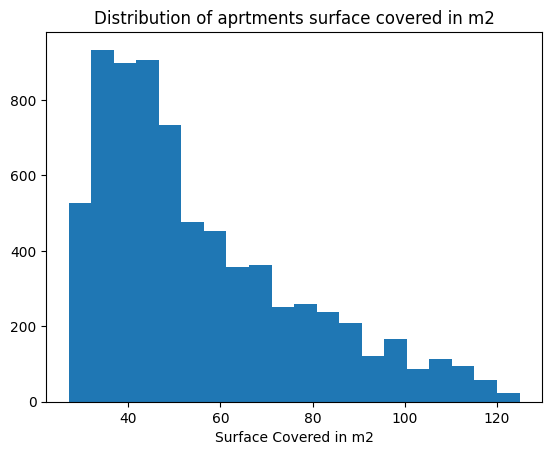

In [6]:
plt.hist(df["surface_covered_in_m2"], bins=20)
plt.xlabel("Surface Covered in m2")
plt.title("Distribution of aprtments surface covered in m2");

In [7]:
df["surface_covered_in_m2"].describe()

count    7264.000000
mean       55.679791
std        22.129235
min        27.000000
25%        38.000000
50%        49.000000
75%        69.250000
max       125.000000
Name: surface_covered_in_m2, dtype: float64

This initial visualization shows that there are outliers values in the surface area covered. I would be removing the outliers as shown in the wrangle function, return values between 5th and 95th quantile.

After removal of outliers:
+ The distribution of the the property area covered is right-skewed. 
+ 50% of properties have surface covered area of 49 _sqm_



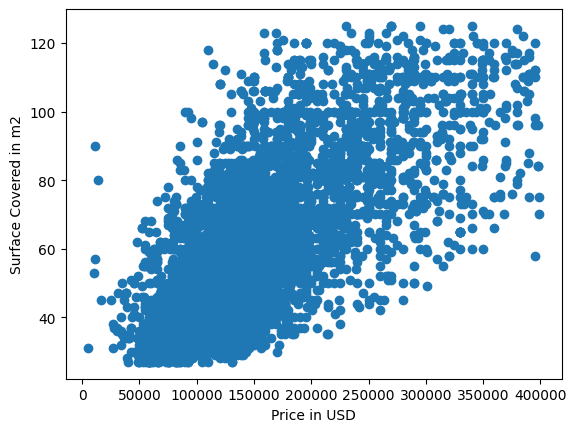

In [8]:
plt.scatter(df["price_aprox_usd"], df["surface_covered_in_m2"],)
plt.ylabel("Surface Covered in m2")
plt.xlabel("Price in USD");

In [9]:
correlation = df["price_aprox_usd"].corr(df["surface_covered_in_m2"])
correlation

np.float64(0.752123782448582)

This shows a quiet positive relationship between surface covered area and the price. A correlation value of 0.75 suggests that the amount of surface covered will influence the price.

In [10]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2"]
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
y_mean = y_train.mean()
y_pred_baseline = [float(y_mean)] * len(y_train)
len(X_train)

5811

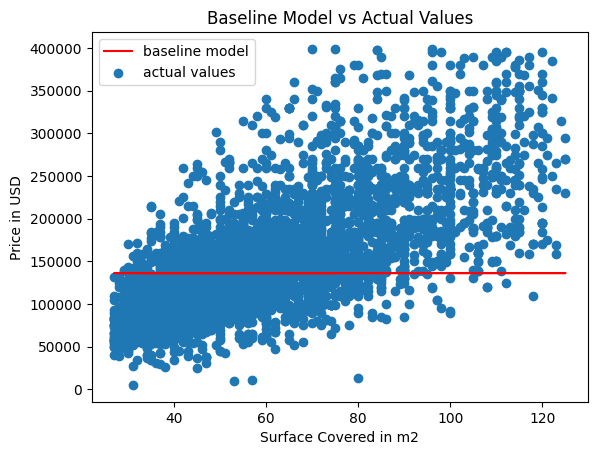

In [12]:
plt.plot(X_train,y_pred_baseline, color="red", label = "baseline model")
plt.scatter(X_train, y_train, label = "actual values")
plt.xlabel("Surface Covered in m2")
plt.ylabel("Price in USD")
plt.title("Baseline Model vs Actual Values")
plt.legend();

In [13]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Baseline MAE:", mae_baseline)

Baseline MAE: 50063.033084344075


In [18]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
mae

32627.868649123706

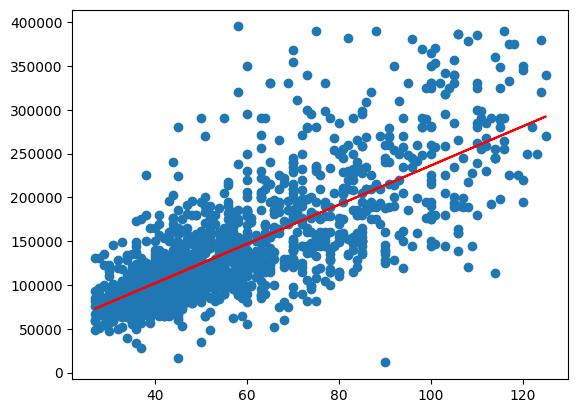

In [19]:
plt.scatter(X_test, y_test, label = "actual values")
plt.plot(X_test, y_pred, color="red", label = "predicted values");

Linear equation for the linear model

In [25]:
intercept = float(model.intercept_)
coef = float(model.coef_[0])
intercept, coef

(12216.469441696361, 2240.4509266311384)

In [30]:
display(Markdown(f"apartment_price = {intercept:.2f} + {coef:.2f} * surface_covered_in_m2"))

apartment_price = 12216.47 + 2240.45 * surface_covered_in_m2

In [ ]:
min_surface = X_train.min()
max_surface = X_train.max()
def predict_price(area_covered):
    input_data = pd.DataFrame([[area_covered]], columns=X_train.columns)
    predicted_price = float(model.predict(input_data)[0])
    return f"Predicted price: {predicted_price:,.2f} USD"

area_covered_widget = widgets.FloatSlider(
    value=50.0,
    min=min_surface,
    max=max_surface,
    step=1.0,
    description='Area Covered (m2):',
    continuous_update=False
)

widgets.interact(predict_price, area_covered=area_covered_widget);

c:\Users\Okoko\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\traitlets.py:2809: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(value)


interactive(children=(FloatSlider(value=50.0, continuous_update=False, description='Area Covered (m2):', max=1…